In [19]:
import numpy as np
import hail as hl
from hail import methods
import scipy as sp
import pandas as pd
from math import sqrt, pi
from random import randint, choice
import matplotlib.pyplot as plt
import pandas as pd
import time

## Create genetic data (and clean/process/edit, these cells are retired now, the code to run is in the last cell at the bottom of the notebook)

In [2]:
# retired - no longer using for data generation
def makeData(model_input, group_size):
    mt = hl.balding_nichols_model(*model_input)
    mt.write("balding_nichols_test.mt")
    mt = hl.read_matrix_table("balding_nichols_test.mt")
    mt = mt.transmute_entries(n_alt = hl.float64(mt.GT.n_alt_alleles())) 
    table = mt.localize_entries("ent", "sample")
    table = matrix_table_to_table_of_ndarrays(mt.n_alt, group_size, tmp_path='/tmp/test_table.ht')
#     table = table.key_by(hl.int32(table.row_group_number))
    return table
    
# data = makeData((3, 100, 1000), 4)

# (n, m) = (100, 1000)
# k = 50
# l = k + 2
# q = 0

# G = hl.nd.array(np.random.normal(0, 1, (n,l)))

## Grouping and NDArray methods from Tim and Dan

In [3]:
# Functions for operating with Tables of ndarrays in Hail (from Tim)

from hail.expr import Expression, ExpressionException, \
    expr_float64, expr_call, expr_any, expr_numeric, expr_array, \
    expr_locus, \
    analyze, check_entry_indexed, check_row_indexed, \
    matrix_table_source, table_source

# Only groups by rows, NOT COLUMNS
def matrix_table_to_table_of_ndarrays(field, group_size, tmp_path = '/tmp/nd_table.ht'):
    """

    The returned table has two fields: 'row_group_number' and 'ndarray'.

    Examples
    --------
    >>> ht = matrix_table_to_table_of_ndarrays(mt.GT.n_alt_alleles(), 100)

    Parameters
    ----------
    field
    group_size
    tmp_path

    Returns
    -------

    """
    mt = matrix_table_source('matrix_table_to_table_of_ndarrays/x', field)
    mt = mt.select_entries(x = field)
    ht = mt.localize_entries(entries_array_field_name='entries')
    # now ht.entries is an array of structs with one field, x

    # we'll also want to mean-impute/variance-normalize/etc here
    ht = ht.select(xs = ht.entries.map(lambda e: e['x']))
    # now ht.xs is an array of float64

    # now need to produce groups of G
    ht = ht.add_index()
    ht = ht.group_by(row_group_number= hl.int32(ht.idx // group_size)) \
        .aggregate(ndarray=hl.nd.array(hl.agg.collect(ht.xs)))
    # may require a .T on ndarray

    return ht.checkpoint(tmp_path, overwrite=True)

def chunk_ndarray(a, group_size):
    """Chunks a NDarray along the first axis in chunks of `group_size`.
    Parameters
    ----------
    a
    group_size
    -------

    """
    n_groups = a.shape[0] // group_size
    groups = []
    for i in range(a.shape[0] // group_size):
        start = i * group_size
        end = (i + 1) * group_size
        groups.append(a[start:end, :])
    return groups


# Concatenate the ndarrays with a blocked Table
def concatBlocked(A):
    blocks = A.ndarray.collect()
    big_mat = np.concatenate(blocks, axis=0)
    ht = ndarray_to_table([big_mat])
    
    block_shape = blocks[0].shape
    
    tup = ht.ndarray.collect()[0].shape
    assert tup == (len(blocks) * block_shape[0], block_shape[1])
    
    return ht

def concatToNumpy(A):
    blocks = A.ndarray.collect()
    big_mat = np.concatenate(blocks, axis=0)
    return big_mat

def ndarray_to_table(chunked_arr):
    structs = [hl.struct(row_group_number = idx, ndarray = block)
               for idx, block in enumerate(chunked_arr)]
    ht = hl.Table.parallelize(structs)
    ht = ht.key_by('row_group_number')
    return ht

# function to multiply two blocks, given the two blocks
# returns struct in form of array but not ndarray, includes the shape in the struct
# to change the result product directly back into a ndarray we need to use from_column_major
def block_product(left, right):
    product = left @ right
    n_rows, n_cols = product.shape
    return hl.struct(
        shape=product.shape,
        block=hl.range(hl.int(n_rows * n_cols)).map(
            lambda absolute: product[absolute % n_rows, absolute // n_rows]))

# takes in output of block_product
def block_aggregate(prod):
    shape = prod.shape
    block = prod.block
    return hl.nd.from_column_major(
        hl.agg.array_sum(block),
        hl.agg.take(shape, 1)[0])

# returns flat array
def to_column_major(ndarray):
    n_rows, n_cols = ndarray.shape
    return hl.range(hl.int(n_rows * n_cols)).map(
        lambda absolute: ndarray[absolute % n_rows, absolute // n_rows])

# hl.nd.from_column_major(thing.the_sum, thing.the_shape)

## Blanczos Algorithm

In [4]:
# Algorithm step: multiplying H0 = A @ G

# METHOD
# Multiply a row-blocked matrix by a local non-blocked matrix
# First step of algorithm

# Usage:
# assumes blocks in blocked matrix are named ndarray
# A is a table, B is a Hail ndarray
# returns a table

# Example:
# H0 = matmul_rowblocked_nonblocked(data, G)

def matmul_rowblocked_nonblocked(A, B):
    temp = A.annotate_globals(mat = B)
    temp = temp.annotate(ndarray = temp.ndarray @ temp.mat)
    temp = temp.select(temp.ndarray)
    temp = temp.drop(temp.mat)
    return temp


# Algorithm step: intermediate operation of multiplying At @ (A @ G) = At @ H0

# METHOD
# Multiply a column-blocked matrix by a row-blocked matrix 
# as a blockmatrix multiplcation and then sum
# Second step of algorithm

# Usage:
# pass in matrix A normally, blocked in rows - this specifically expects A to need to be transposed
# assumes blocks in blocked matrix are named ndarray
# A and B are both tables
# returns a hail ndarray

# Example:
# G1 = matmul_colblocked_rowblocked(data, H0)

def matmul_colblocked_rowblocked(A, B):
    temp = A.transmute(ndarray = block_product(A.ndarray.transpose(), B[A.row_group_number].ndarray))
    result_arr_sum = temp.aggregate(block_aggregate(temp.ndarray))
    return result_arr_sum


def matmul_nonblocked_rowblocked(B, A):
    pass


# Algorithm step: perform QR decomposition of Hq and compute T = Q^T @ A
# Perform QR decomposition of a row-blocked matrix
# Third and fourth step of algorithm

def computeNextH(A, H):
    nextG = matmul_colblocked_rowblocked(A, H)
    return matmul_rowblocked_nonblocked(A, nextG)

In [5]:
def hailBlanczos(A, G, m, n, k, l, q):
    
    # assert l > k
    # assert (q+1)*l <= (n - k)
    # assert n <= m
    
    start = time.time()
    
    Hi = matmul_rowblocked_nonblocked(A, G)
    npH = concatToNumpy(Hi)
    for j in range(0, q):
        Hj = computeNextH(A, Hi)
        npH = np.concatenate((npH, concatToNumpy(Hj)), axis=1)
        Hi = Hj
    
    # assert npH.shape == (m, (q+1)*l)
    # perform QR decomposition on unblocked version of H
    Q, R = np.linalg.qr(npH)
    # assert Q.shape == (m, (q+1)*l)
    
    # block Q's rows into the same number of blocks that A has
    num_blocks = A.count() # fix
    group_size_Q = Q.shape[0] // num_blocks
    #assert group_size_Q * num_blocks == m
    blocked_Q_table = ndarray_to_table(chunk_ndarray(Q, group_size_Q))
    
    T = matmul_colblocked_rowblocked(blocked_Q_table, A)
    # assert T.shape == ((q+1)*l, n)

    U, S, W = np.linalg.svd(T, full_matrices=False)
    # assert U.shape == ((q+1)*l, n)
    # assert S.shape == (n,)
    # assert W.shape == (n, n)
    
    sing_val = S[k]
    
    V = matmul_rowblocked_nonblocked(blocked_Q_table, U)
    arr_V = concatToNumpy(V)
    
    end = time.time()
    
    truncV = arr_V[:,:k]
    truncS = S[:k]
    truncW = W[:k,:]
    
    bound, satC = blanczosErrorB(truncV, np.diag(truncS), truncW.transpose(), m, n, k, q, concatToNumpy(A), sing_val)
    print("Satisfies Blanczos error bound equation 4.3 if C=1: ", bound)
    
    return truncV, truncS, truncW, sing_val, Q, bound, satC, end - start

# def hailBlanczos(A, G):
#     H0 = matmul_rowblocked_nonblocked(A, G)
#     T, Q, table_Q = processH(H0, A)
#     u, s, w = processT(T)
#     V, S, W = computeV(u, s, w, table_Q)
#     return V, S, W

In [6]:
# T, Q, table_Q = processH(H0, data)
# print('Q shape', Q.shape)

# u, s, w = processT(T)
# V, S, W = computeV(u, s, w, table_Q)
# arr_V = concatToNumpy(V)
# print('V shape:', arr_V.shape, 'S shape:', S.shape, 'W shape:', W.shape)

## NumPy implementation from other notebook

In [13]:
# ALL TRANSPOSED FROM ABOVE IMPLEMENTATION

def hwe_normalize(call_expr):
    mt = call_expr._indices.source
    mt = mt.select_entries(__gt=call_expr.n_alt_alleles())
    mt = mt.annotate_rows(__AC=hl.agg.sum(mt.__gt),
                          __n_called=hl.agg.count_where(hl.is_defined(mt.__gt)))
    mt = mt.filter_rows((mt.__AC > 0) & (mt.__AC < 2 * mt.__n_called))

    n_variants = mt.count_rows()
    if n_variants == 0:
        raise FatalError("hwe_normalized: found 0 variants after filtering out monomorphic sites.")

    mt = mt.annotate_rows(__mean_gt=mt.__AC / mt.__n_called)
    mt = mt.annotate_rows(
        __hwe_scaled_std_dev=hl.sqrt(mt.__mean_gt * (2 - mt.__mean_gt) * n_variants / 2))
    mt = mt.unfilter_entries()

    normalized_gt = hl.or_else((mt.__gt - mt.__mean_gt) / mt.__hwe_scaled_std_dev, 0.0)
    return normalized_gt

#Blanczos paper error bound 4.23
def blanczosErrorA(U, S, V, m, n, k, q, A, k1th_sing_val):
    norm_diff = np.linalg.norm(A - U @ S @ V.transpose())
    bound = 100 * l * (((m-k)/l) ** (1/(4*q + 2))) * k1th_sing_val
    print('value:', norm_diff, 'bound/upper limit:', bound)
    return norm_diff <= bound

def blanczosErrorB(U, S, V, m, n, k, q, A, k1th_sing_val):
    C = 1
    norm_diff = np.linalg.norm(A - U @ S @ V.transpose())
    bound = C * (m ** (1/(4*q))) * k1th_sing_val
    satisfyingC = norm_diff / bound
    print('difference A - USV:', norm_diff, 'bound/upper limit:', bound)
    print('C constant needed to satisfy bound:', satisfyingC)
    return norm_diff <= bound, satisfyingC

def normQQtA(A, Q):
    return np.linalg.norm(A - Q @ Q.transpose() @ A)

def numpyBlanczos(A, m, n, k, l, q, G):

    assert l > k
    # assert (q+1)*l <= (m - k)
    assert m <= n

    # G = np.random.normal(0, 1, (l, m))
    R = G @ A
    # AtA = A.transpose() @ A
    listR = [R]
    for i in range(0, q):
        Ri = (listR[i] @ A.transpose()) @ A
        listR.append(Ri)
        R = np.concatenate((R, Ri), axis=0)

    assert R.shape == ((q+1)*l, n)
    (Q, S) = np.linalg.qr(R.transpose())
    assert Q.shape == (n, (q+1)*l)
    assert S.shape == ((q+1)*l, (q+1)*l)

    T = A @ Q
    assert T.shape == (m, (q+1)*l)
    
    (Tu, Ts, Tw) = np.linalg.svd(T, full_matrices=False)
    assert Tu.shape, (m, (q+1)*l)
    print(Ts.shape, (q+1)*l)
    assert Ts.shape == ((q+1)*l,)
    assert Tw.shape == ((q+1)*l, (q+1)*l)
    
    sing_val = Ts[k]
    
    V = Q @ Tw
    
    bound = blanczosErrorB(Tu, np.diag(Ts), V, m, n, k, q, A, sing_val)
    print("Satisfies Blanczos error bound equation 4.3 if C=1: ", bound)
    
    return Tu[:,:k], Ts[:k], V[:k,:], sing_val, Q


# mt = hl.balding_nichols_model(3, 10000, 1000)
# norm_gt = hwe_normalize(mt.GT)
# np_matrix = hl.linalg.BlockMatrix.from_entry_expr(norm_gt).to_numpy()

# npA = np.asmatrix(np_matrix)
# print(npA.shape)
# npm, npn = npA.shape
# npk = 50
# npl = npk + 2
# npq = 0

# (blanczosU, blanczosS, blanczosV) = blanczosSVD(npA, npm, npn, npk, npl, npq)

## Run NumPy and Hail implementations on the same data

In [8]:
def makeSharedData(model_input, block_size):
    
    # we should have m > n for hail implementation
    mt = hl.balding_nichols_model(*model_input)
    
    mt.write("balding_nichols_data.mt", overwrite=True)
    mt = hl.read_matrix_table("balding_nichols_data.mt")
    
    mt = mt.transmute_entries(n_alt = hl.float64(mt.GT.n_alt_alleles())) 
    table = matrix_table_to_table_of_ndarrays(mt.n_alt, block_size, tmp_path='/tmp/test_table.ht')
    
    # for numpy implementation we want transposed version so m < n
    np_matrix = np.asmatrix(concatToNumpy(table).transpose())

    return table, np_matrix

m = 1000
n = 100
block_size = 4
hailA, numpyA = makeSharedData((3, n, m), block_size)

# doesn't account for differences due to transposing
# hailV not necessarily supposed to be the same as blanczosU

Initializing Hail with default parameters...
Running on Apache Spark version 2.4.1
SparkUI available at http://annamiras-air.home:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.53-c0eab3a973f1
LOGGING: writing to /Users/annamira/Documents/GitHub/hail/hail/python/hail/linalg/hail-20200803-1954-0.2.53-c0eab3a973f1.log
2020-08-03 19:54:52 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 1000 variants...
2020-08-03 19:54:58 Hail: INFO: Coerced sorted dataset
2020-08-03 19:55:01 Hail: INFO: wrote matrix table with 1000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-03 19:55:05 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-03 19:55:06 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht


In [9]:
k = 30
l = k + 2
q = 5
G = np.random.normal(0, 1, (n,l))

In [11]:
hailV, hailS, hailW, hailSingVal, hailQ, _, _, _ = hailBlanczos(hailA, hl.nd.array(G), m, n, k, l, q)

2020-08-03 19:57:36 Hail: INFO: Coerced sorted dataset
2020-08-03 19:57:41 Hail: INFO: Coerced sorted dataset


difference A - USV: 144.30975763897442 bound/upper limit: 29.132334402698255
C constant needed to satisfy bound: 4.953594025256292
Satisfies Blanczos error bound equation 4.3 if C=1:  False


In [30]:
#numpyU, numpyS, numpyV, numpySingVal, numpyQ = numpyBlanczos(numpyA, n, m, k, l, q, G.transpose())

In [29]:
# print('largest singular value from hail:', hailS[0])
# print('smallest singular value from hail:', hailS[k-1])
# print(hailS.shape)
# print(numpyS.shape)
# hailS - numpyS

In [28]:
# normQQtA(numpyA.transpose(), hailQ)

In [27]:
# print(numpyA.shape)
# print(numpyQ.shape)
# normQQtA(numpyA, numpyQ.transpose())

In [18]:

df = pd.DataFrame(columns=['M', 'N', 'block size', 'K', 'L', 'Q', 'time', 'C'])

# references a dataframe df not passed into the function
def loop(i, m, n, block_size, k, l, q):

    try: 
        assert l > k
        assert n <= m
    except:
        return

    try:
        table, mat = makeSharedData((3, n, m), block_size)
    except:
        print('failed to make data with ', (m, n))
    
    try:
        G = hl.nd.array(np.random.normal(0, 1, (n,l)))
        _, S, _, _, _, _, C, time_passed = hailBlanczos(table, G, m, n, k, l, q)
        df.loc[i] = [m, n, block_size, k, l, q, time_passed, C]
    except:
        print('failed during blanczos algorithm with ', (m, n))
        
    return


for i in range(1, 10):
    
    randN = 100 * randint(1, 100) #100
    randM = 100 * randint(1, 500) #1000
    randBlockSize = choice([2, 4, 10, 20, 25, 50])
    randK = randint(1, 100)
    randL = randint(1, 20) + randK
    randQ = randint(1, 5)
    
    loop(i, randM, randN, randBlockSize, randK, randL, randQ)
    
    
blanczos_data = df.to_csv('blanczos_data_1.csv')    
    
    
    

2020-08-03 20:01:47 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 400 samples, and 900 variants...
2020-08-03 20:01:48 Hail: INFO: Coerced sorted dataset
2020-08-03 20:01:49 Hail: INFO: wrote matrix table with 900 rows and 400 columns in 8 partitions to balding_nichols_data.mt
2020-08-03 20:01:50 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-03 20:01:51 Hail: INFO: wrote table with 90 rows in 8 partitions to /tmp/test_table.ht
2020-08-03 20:01:58 Hail: INFO: Coerced sorted dataset
2020-08-03 20:02:00 Hail: INFO: Coerced sorted dataset


difference A - USV: 327.01596216779274 bound/upper limit: 59.170269536528316
C constant needed to satisfy bound: 5.526693806353407
Satisfies Blanczos error bound equation 4.3 if C=1:  False


2020-08-03 20:02:01 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 600 samples, and 1500 variants...
2020-08-03 20:02:01 Hail: INFO: Coerced sorted dataset
2020-08-03 20:02:02 Hail: INFO: wrote matrix table with 1500 rows and 600 columns in 8 partitions to balding_nichols_data.mt
2020-08-03 20:02:03 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-03 20:02:04 Hail: INFO: wrote table with 375 rows in 8 partitions to /tmp/test_table.ht
2020-08-03 20:02:10 Hail: INFO: Coerced sorted dataset
2020-08-03 20:02:13 Hail: INFO: Coerced sorted dataset


difference A - USV: 553.0601673580554 bound/upper limit: 204.99526354196135
C constant needed to satisfy bound: 2.697916809403975
Satisfies Blanczos error bound equation 4.3 if C=1:  False


2020-08-03 20:02:14 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 1000 samples, and 2100 variants...
2020-08-03 20:02:14 Hail: INFO: Coerced sorted dataset
2020-08-03 20:02:16 Hail: INFO: wrote matrix table with 2100 rows and 1000 columns in 8 partitions to balding_nichols_data.mt
2020-08-03 20:02:17 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-03 20:02:19 Hail: INFO: wrote table with 42 rows in 8 partitions to /tmp/test_table.ht
2020-08-03 20:03:00 Hail: INFO: Coerced sorted dataset
2020-08-03 20:03:19 Hail: INFO: Coerced sorted dataset


difference A - USV: 758.164814357268 bound/upper limit: 74.31347351570726
C constant needed to satisfy bound: 10.20225241115958
Satisfies Blanczos error bound equation 4.3 if C=1:  False


2020-08-03 20:03:26 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 600 samples, and 2800 variants...
2020-08-03 20:03:26 Hail: INFO: Coerced sorted dataset
2020-08-03 20:03:28 Hail: INFO: wrote matrix table with 2800 rows and 600 columns in 8 partitions to balding_nichols_data.mt
2020-08-03 20:03:28 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-03 20:03:30 Hail: INFO: wrote table with 112 rows in 8 partitions to /tmp/test_table.ht
2020-08-03 20:03:56 Hail: INFO: Coerced sorted dataset
2020-08-03 20:04:10 Hail: INFO: Coerced sorted dataset


difference A - USV: 666.8245316053393 bound/upper limit: 102.31109661974854
C constant needed to satisfy bound: 6.517616892365768
Satisfies Blanczos error bound equation 4.3 if C=1:  False


2020-08-03 20:04:17 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 400 samples, and 400 variants...
2020-08-03 20:04:18 Hail: INFO: Coerced sorted dataset
2020-08-03 20:04:19 Hail: INFO: wrote matrix table with 400 rows and 400 columns in 8 partitions to balding_nichols_data.mt
2020-08-03 20:04:19 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-03 20:04:20 Hail: INFO: wrote table with 200 rows in 8 partitions to /tmp/test_table.ht
2020-08-03 20:04:33 Hail: INFO: Coerced sorted dataset
2020-08-03 20:04:39 Hail: INFO: Coerced sorted dataset


difference A - USV: 153.36584776497884 bound/upper limit: 23.247658810376176
C constant needed to satisfy bound: 6.597044847222497
Satisfies Blanczos error bound equation 4.3 if C=1:  False


2020-08-03 20:04:40 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 300 samples, and 2800 variants...
2020-08-03 20:04:40 Hail: INFO: Coerced sorted dataset
2020-08-03 20:04:41 Hail: INFO: wrote matrix table with 2800 rows and 300 columns in 8 partitions to balding_nichols_data.mt
2020-08-03 20:04:42 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-03 20:04:43 Hail: INFO: wrote table with 140 rows in 8 partitions to /tmp/test_table.ht
2020-08-03 20:05:10 Hail: INFO: Coerced sorted dataset
2020-08-03 20:05:28 Hail: INFO: Coerced sorted dataset


difference A - USV: 411.91163149816924 bound/upper limit: 66.58898216694622
C constant needed to satisfy bound: 6.18588268049299
Satisfies Blanczos error bound equation 4.3 if C=1:  False


In [20]:
df

,M,N,block size,K,L,Q,time,C
1,900.0,400.0,10.0,28.0,31.0,2.0,8.253199,5.526694
3,1500.0,600.0,4.0,15.0,27.0,1.0,7.109660,2.697917
4,2100.0,1000.0,50.0,94.0,105.0,3.0,59.511663,10.202252
5,2800.0,600.0,25.0,83.0,88.0,2.0,39.787925,6.517617
8,400.0,400.0,2.0,87.0,99.0,4.0,19.304291,6.597045
9,2800.0,300.0,20.0,90.0,92.0,3.0,46.113614,6.185883


In [23]:
df['MxN'] = df.apply(lambda row: row.M * row.N, axis=1)
df

,M,N,block size,K,L,Q,time,C,MxN
1,900.0,400.0,10.0,28.0,31.0,2.0,8.253199,5.526694,360000.0
3,1500.0,600.0,4.0,15.0,27.0,1.0,7.109660,2.697917,900000.0
4,2100.0,1000.0,50.0,94.0,105.0,3.0,59.511663,10.202252,2100000.0
5,2800.0,600.0,25.0,83.0,88.0,2.0,39.787925,6.517617,1680000.0
8,400.0,400.0,2.0,87.0,99.0,4.0,19.304291,6.597045,160000.0
9,2800.0,300.0,20.0,90.0,92.0,3.0,46.113614,6.185883,840000.0


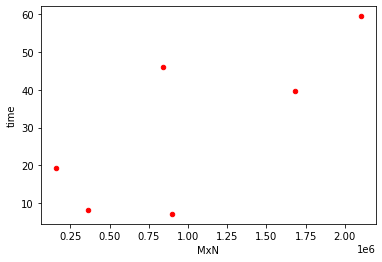

In [26]:
df.plot(kind='scatter',x='MxN',y='time',color='red')
plt.show()